---
title: Heatwave in Netherlands 
subtitle: Learn how to read, process and use Sentinel-3 Land Surface Temperature
authors:
  - name: Yuvraj Adagale
    orcid: 0009-0008-1259-3399
    github: Yuvraj198920
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
tags: ["xarray", "sentinel-3", "climate-change"]
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
releaseDate: 2025-07-15
datePublished: 2025-07-15
dateModified: 2025-07-15
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

# Table of Contents

0. [Preface](#Preface_HEAT)
1. [Introduction](#Introduction_HEAT)
2. [Setup](#Setup_HEAT)
3. [Data Access](#Data_Access_HEAT)
4. [Sentinel-3 Preprocessing](#Preprocessing_HEAT)
5. [Data Loading](#Data_Loading_HEAT)
6. [Heatwave Algorithm](#Heatwave_Algorithm_HEAT)
7. [Interactive Visualization](#Interactive_HEAT)
8. [Static Visualization](#Static_HEAT)

---

(Preface_HEAT)=
## Preface

The original notebook used as a starting point for this work is a Copernicus Data Space Ecosystem example, [available here](https://documentation.dataspace.copernicus.eu/APIs/openEO/openeo-community-examples/python/Heatwave/HeatwaveNL.html).  
The example has been adapted to use the data provided by the EOPF Sentinel Zarr Samples project instead of the openEO API.

(Introduction_HEAT)=
## Introduction

As an impact of global warming, an increase in temperature has been reported, which can lead to potential health risks and environmental stress. Several research studies have been presented over the years, such as in this [paper](https://www.mdpi.com/2072-4292/14/3/561), where they explain the change in Land surface temperature over several regions.

Thus, in this notebook, we want to showcase a tool for mapping heatwaves using Sentinel-3 products. For this, we focused on the Netherlands and used specific conditions proposed by the [“National Heatwave Plan”](https://www.rivm.nl/en/heat/national-heatwave-plan) in the Netherlands. The condition implies:

```
5 days >25 and 3 days >30
```

Moreover, in De Bilt, a municipality in the province of Utrecht had a temperature of 25°C at least five days in a row, with at least three days hotter than 30 °C.


This notebook demonstrates how to analyze and visualize heatwave events in the Netherlands using Sentinel-3 Land Surface Temperature (LST) data in Zarr format. Leveraging the EOPF (Earth Observation Processing Framework) and Jupyter Notebook template, you will learn how to efficiently access, process, and interpret large volumes of satellite data from cloud object storage.

The workflow will guide you through:

- Accessing and filtering Sentinel-3 LST datasets for a specific time range and area of interest (AOI)
- Grouping and reading Zarr data in parallel using Dask for scalable analysis
- Merging measurement and quality datasets to enable robust computation
- Preparing data for downstream tasks such as heatwave detection, cloud masking, and visualization

By the end of this notebook, you will gain practical skills for working with cloud-based geospatial time series using Python, and a deeper understanding of environmental monitoring with open satellite data.

:::{hint} Overview

**Questions**
- How does the notebook load and merge Sentinel-3 LST data from remote Zarr files?
- How does the workflow filter datasets based on a specific date range and geographic area of interest?
- What role does Dask play in enabling efficient parallel data processing?
- How is the heatwave detection algorithm implemented using 5-day rolling sums and threshold conditions?

**Objectives**
- Demonstrate how to access and process Sentinel-3 LST data in EOPF Zarr format using Xarray
- Show practical steps for identifying and analyzing heatwave events in the Netherlands
:::

(Setup_HEAT)=
## Setup

In this section, we prepare our environment by ensuring the necessary libraries are available. Although most libraries are already imported in previous cells, this step outlines the essential packages used for data handling, visualization, and geospatial analysis.

### Import Required Libraries

In [18]:
import xarray as xr
from distributed import LocalCluster
import folium
from datetime import datetime
import s3fs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json
from scipy.interpolate import griddata
from pathlib import Path
import geopandas as gpd

In [2]:
xr.set_options(keep_attrs=True)

### Dask Cluster Initialization


This creates a local Dask cluster and retrieves its client for distributed parallel processing.


In [3]:
cluster = LocalCluster()
client = cluster.get_client()
client

/home/mclaus@eurac.edu/micromamba/envs/eopf-zarr3/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39177 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39177/status,
Dashboard: http://127.0.0.1:39177/status,Workers: 4
Total threads: 16,Total memory: 62.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44251,Workers: 0
Dashboard: http://127.0.0.1:39177/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41625,Total threads: 4
Dashboard: http://127.0.0.1:43949/status,Memory: 15.70 GiB
Nanny: tcp://127.0.0.1:44747,


### Read AOI and set temporal extent

The area of interest covers The Netherlands and the temporal range covers the summer period of 2023.

In [4]:
def read_json(filename: str) -> dict:
    with open(filename) as input:
        field = json.load(input)
    return field


aoi = read_json("netherlands_export.geojson")

start_date = datetime(2023, 6, 6)
end_date = datetime(2023, 9, 30)

### Visualize Area of Interest

In [5]:
m = folium.Map([52.2, 5], zoom_start=7)
folium.GeoJson(aoi).add_to(m)
m

Calculate the extent of geojson

In [6]:
def calculate_geojson_extent(geojson_path):
    with open(geojson_path) as f:
        geojson_data = json.load(f)
    gdf = gpd.GeoDataFrame.from_features(geojson_data["features"]).explode().cx[0:, :]
    return gdf.total_bounds


geojson_path = Path("netherlands_export.geojson")
extent = calculate_geojson_extent(geojson_path)
print(f"Extent of the geojson: {extent}")

Extent of the geojson: [ 3.349415 50.74755   7.198506 53.558092]


(Data_Access_HEAT)=
## Data Access

We now want to access a time series of Sentinel-3 data to compute the daily heatwave values, remove cloudy pixels, and perform other processing steps.

### List of Available Remote Files

In [7]:
bucket = "e05ab01a9d56408d82ac32d69a5aae2a:sample-data"
prefixes = ["tutorial_data/cpm_v253/", "tutorial_data/cpm_v256/"]
prefix_url = "https://objectstore.eodc.eu:2222"

fs = s3fs.S3FileSystem(anon=True, client_kwargs={"endpoint_url": prefix_url})

# Unregister CEPH handler (required for EODC)
handlers = fs.s3.meta.events._emitter._handlers
handlers_to_unregister = handlers.prefix_search("before-parameter-build.s3")
fs.s3.meta.events._emitter.unregister(
    "before-parameter-build.s3", handlers_to_unregister[0]
)

filtered_urls = []

for prefix in prefixes:
    # Find all potential Sentinel-3 LST datasets
    s3_pattern = f"s3://{bucket}/{prefix}S3[AB]_SL_2_LST____*.zarr"
    candidates = fs.glob(s3_pattern)

    for s3_path in candidates:
        # Convert S3 path to HTTP URL
        http_url = f"{prefix_url}/{s3_path.replace('s3://', '')}"

        # Extract filename from URL
        filename = s3_path.split("/")[-1]

        # Parse sensing start time (4th segment after splitting by '_')
        try:
            # Split: S3B_SL_2_LST____20231029T203741_20231029T204041_...
            time_segment = filename.split("____")[1]
            sensing_start = time_segment.split("_")[0]  # 20231029T203741
            file_date = datetime.strptime(sensing_start[:8], "%Y%m%d")

            if start_date <= file_date <= end_date:
                filtered_urls.append(http_url)

        except (IndexError, ValueError):
            print(f"Skipping malformed filename: {filename}")
            continue

print(
    f"Found {len(filtered_urls)} datasets between {start_date.date()} and {end_date.date()}"
)

Found 813 datasets between 2023-06-06 and 2023-09-30


(Preprocessing_HEAT)=
## Sentinel-3 Preprocessing


Subsetting, cloud masking and regridding Sentinel-3 Land Surface Temperature (LST) data.

In [8]:
def preprocess_slstr(ds):
    """Preprocess SLSTR data: apply cloud mask, subset for Netherlands, and regrid with square pixels."""
    file_path = ds.encoding["source"]
    filename = file_path.split("/")[-1]
    time_str = filename.split("____")[1].split("_")[0]
    dt = datetime.strptime(time_str, "%Y%m%dT%H%M%S")
    time_ns = np.datetime64(dt, "ns")

    # Load 'quality' group from the same Zarr file
    ds_qual = xr.open_dataset(file_path, engine="zarr", group="quality")

    # Apply cloud masking using 'confidence_in' from quality group
    confidence_in = ds_qual["confidence_in"]
    cloud_mask = confidence_in < 16384  # Threshold for cloud-free data
    masked_lst = ds["lst"].where(cloud_mask)

    # Define Netherlands bounding box
    lon_min, lat_min, lon_max, lat_max = extent  # Netherlands extent
    mask = (
        (ds["longitude"] >= lon_min)
        & (ds["longitude"] <= lon_max)
        & (ds["latitude"] >= lat_min)
        & (ds["latitude"] <= lat_max)
    )

    rows, cols = np.where(mask)
    if len(rows) == 0 or len(cols) == 0:
        print(f"No data points found within Netherlands bounds for {filename}")
        return None

    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()

    # Subset the masked LST and coordinates
    masked_lst_subset = masked_lst.isel(
        rows=slice(row_min, row_max + 1), columns=slice(col_min, col_max + 1)
    )
    lat2d = ds["latitude"].isel(
        rows=slice(row_min, row_max + 1), columns=slice(col_min, col_max + 1)
    )
    lon2d = ds["longitude"].isel(
        rows=slice(row_min, row_max + 1), columns=slice(col_min, col_max + 1)
    )

    # Regrid with square pixels using resolution
    target_resolution = 0.01
    n_points_lat = int(np.ceil((lat_max - lat_min) / target_resolution)) + 1
    n_points_lon = int(np.ceil((lon_max - lon_min) / target_resolution)) + 1
    lon_grid, lat_grid = np.meshgrid(
        np.linspace(lon_min, lon_max, n_points_lon),
        np.linspace(lat_min, lat_max, n_points_lat),
    )

    regridded_lst = griddata(
        (lon2d.values.ravel(), lat2d.values.ravel()),
        masked_lst_subset.values.ravel(),
        (lon_grid, lat_grid),
        method="linear",
    )

    # Create a new dataset with regridded data
    regridded_ds = xr.Dataset(
        data_vars={"lst": (["lat", "lon"], regridded_lst)},
        coords={"lat": lat_grid[:, 0], "lon": lon_grid[0, :], "time": time_ns},
    )

    return regridded_ds

(Data_Loading_HEAT)=
## Data Loading

**Please note: the regridding operation requires to load the data (i.e. downloading it) and it will take up to 5 minutes for all the selected scenes.**

In [9]:
ds_meas = xr.open_mfdataset(
    filtered_urls,  # List of Zarr file paths
    engine="zarr",
    group="measurements",
    preprocess=preprocess_slstr,
    combine="nested",
    concat_dim="time",
    chunks="auto",
    parallel=True,
    consolidated=True,
)

In [10]:
ds_meas

<xarray.Dataset> Size: 710MB
Dimensions:  (time: 813, lat: 283, lon: 386)
Coordinates:
  * lat      (lat) float64 2kB 50.75 50.76 50.77 50.78 ... 53.54 53.55 53.56
  * lon      (lon) float64 3kB 3.349 3.359 3.369 3.379 ... 7.179 7.189 7.199
  * time     (time) datetime64[ns] 7kB 2023-06-06T10:47:36 ... 2023-09-30T21:...
Data variables:
    lst      (time, lat, lon) float64 710MB nan 303.8 303.7 ... nan nan nan

Group the data by day to merge multiple Sentinel-3 slices and take the maximum temperature for each day.  
We can now visualize some of the regridded and grouped Sentinel-3 Land Surface Temperature data.  
**Please note that the unit of the Land Surface Temperature (LST) layer is Kelvin (0 K = -273.15 °C).**

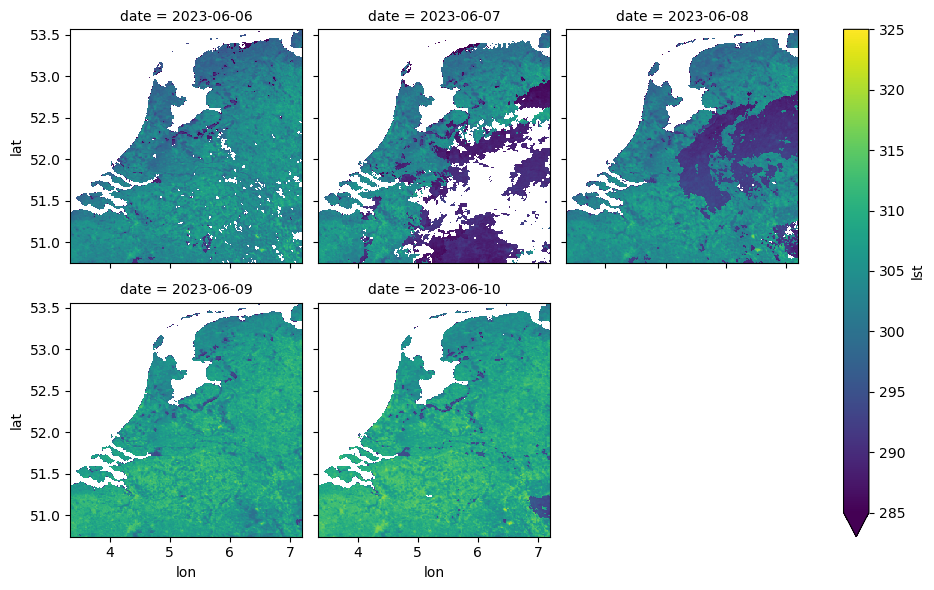

In [11]:
ds_meas_grouped = ds_meas.groupby("time.date").max("time")
# visualize the grouped dataset, only the first 5 dates
ds_meas_grouped.isel(date=slice(0, 5))["lst"].plot(
    x="lon", y="lat", col="date", col_wrap=3, cmap="viridis", vmin=285, vmax=325
)

(Heatwave_Algorithm_HEAT)=
## Heatwave Algorithm

Analyze monthly heatwave events across the Netherlands in 2023 and a visualise the results

Since the previous definition of heatwave defines it with temperature values in degrees, we have to convert them firstly to Kelvin:  

$25 °C = 298,15 K$  

$30 °C = 303,15 K$  

We are now ready to check if we had:

1. At least five days in a row with a temperature of 25 °C or higher
2. Three out of five days with a temperature of 30 °C or higher

In [12]:
condition_all_above_298 = (
    (ds_meas_grouped > 298.15)
    .rolling(date=5, center=True)
    .construct("window_dim")
    .all(dim="window_dim")
    .astype("bool")
)

condition_at_least_3_above_303 = (ds_meas_grouped > 303.15).rolling(
    date=5, center=True
).sum() >= 3

heatwave_count = (condition_all_above_298 & condition_at_least_3_above_303).sum("date")

heatwave_count

<xarray.Dataset> Size: 879kB
Dimensions:  (lat: 283, lon: 386)
Coordinates:
  * lat      (lat) float64 2kB 50.75 50.76 50.77 50.78 ... 53.54 53.55 53.56
  * lon      (lon) float64 3kB 3.349 3.359 3.369 3.379 ... 7.179 7.189 7.199
Data variables:
    lst      (lat, lon) int64 874kB 1 1 4 8 8 8 8 8 8 7 ... 0 2 4 4 4 2 2 0 0 0

(Interactive_HEAT)=
## Interactive Visualization

Using Folium, we can easily create an interactive map with a background that allows us to easily spot areas affected by heatwaves.

In [41]:
lon, lat = np.meshgrid(heatwave_count.lon.values, heatwave_count.lat.values)
cm = matplotlib.colormaps.get_cmap("hot_r")
colored_data = cm(np.flip(np.flip(heatwave_count.lst), axis=1) / 20)


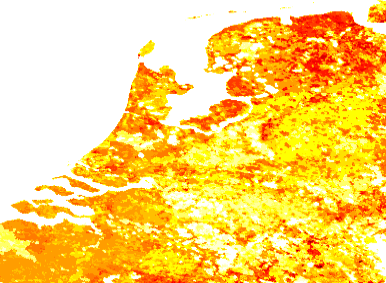

In [42]:
m = folium.Map(location=[lat.mean(), lon.mean()], zoom_start=8)
folium.raster_layers.ImageOverlay(
    colored_data,
    [[lat.min(), lon.min()], [lat.max(), lon.max()]],
    mercator_project=True,
    opacity=0.5,
).add_to(m)
m

(Static_HEAT)=
## Static Visualization

Using cartopy, we can create a static plot.

Text(0.5, 1.0, 'Number of days with Heatwave in 2023')

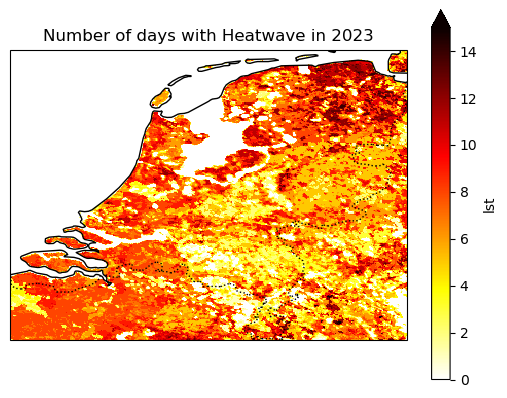

In [47]:
axes = plt.axes(projection=ccrs.PlateCarree())
axes.coastlines()
axes.add_feature(cfeature.BORDERS, linestyle=":")
heatwave_count.lst.plot.imshow(vmin=0, vmax=15, ax=axes, cmap="hot_r")
axes.set_title("Number of days with Heatwave in 2023")

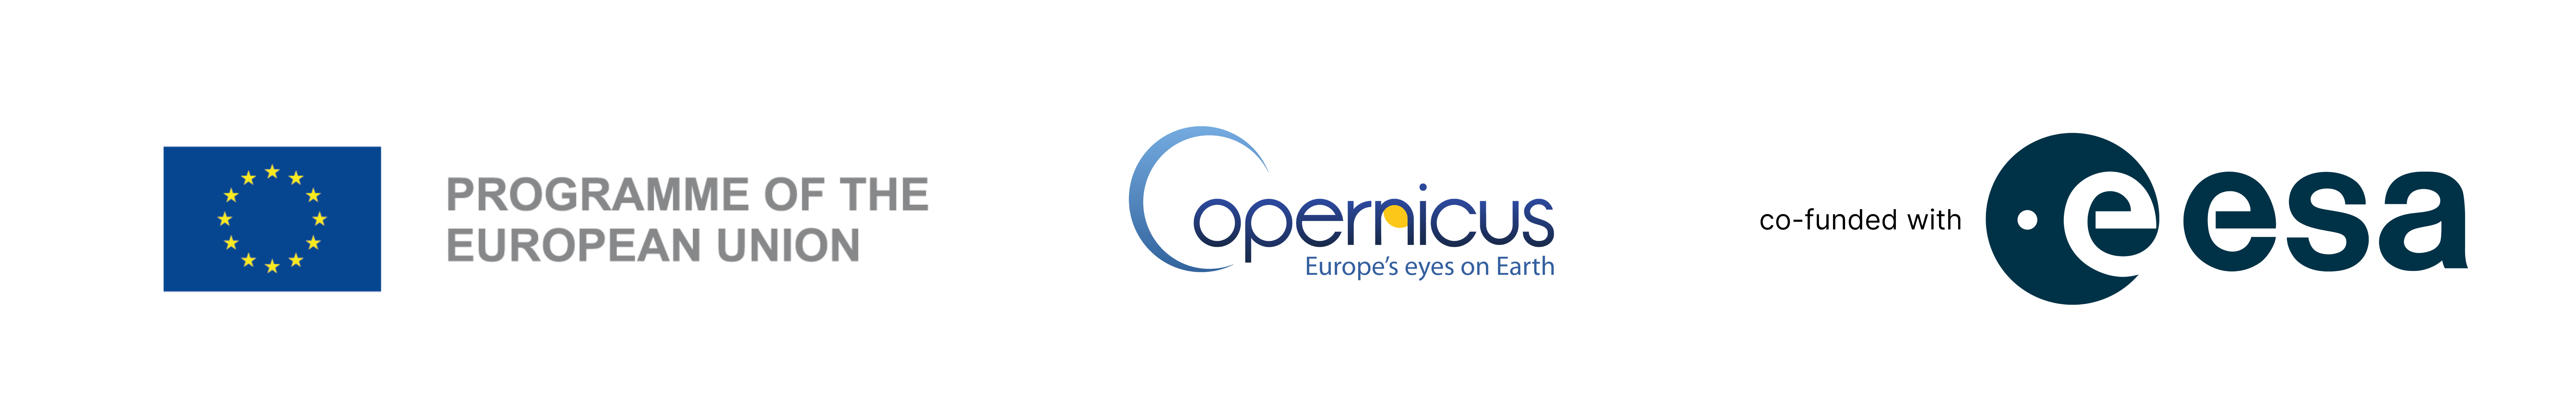